In [1]:
import os.path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from gensim.downloader import load
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist #used to determine number of tokens
from gensim.models import Word2Vec

In [2]:
with open("goemotions.json", "r") as read_content:
    file = pd.read_json(read_content)

Taking count of all sentiment and emotion tags respectively associated with Reddit posts. Then creating a dictionary to create key-value pairings.

In [3]:
print(file.loc[file[0]=='They have THE BEST tortillas too. Made right in front of you. Mmmmmm!'])

                                                        0           1  \
264     They have THE BEST tortillas too. Made right i...     neutral   
23540   They have THE BEST tortillas too. Made right i...     neutral   
73369   They have THE BEST tortillas too. Made right i...  admiration   
86008   They have THE BEST tortillas too. Made right i...  admiration   
115605  They have THE BEST tortillas too. Made right i...    approval   

               2  
264      neutral  
23540    neutral  
73369   positive  
86008   positive  
115605  positive  


In [4]:
sentiment = file[2].value_counts().to_dict()
sentiment_values = sentiment.keys()
sentiment_frequency = sentiment.values()

In [5]:
emotion = file[1].value_counts().to_dict()
emotion_values = emotion.keys()
emotion_frequency = emotion.values()

In [6]:
# print(emotion)
# emotion_list = list(emotion_frequency)
# pdP = pd.Series(emotion_list)
# print(pdP.describe())

In [7]:
# print(sentiment)
# sentiment_list = list(sentiment_frequency)
# pdP = pd.Series(sentiment_list) 
# print(pdP.describe())

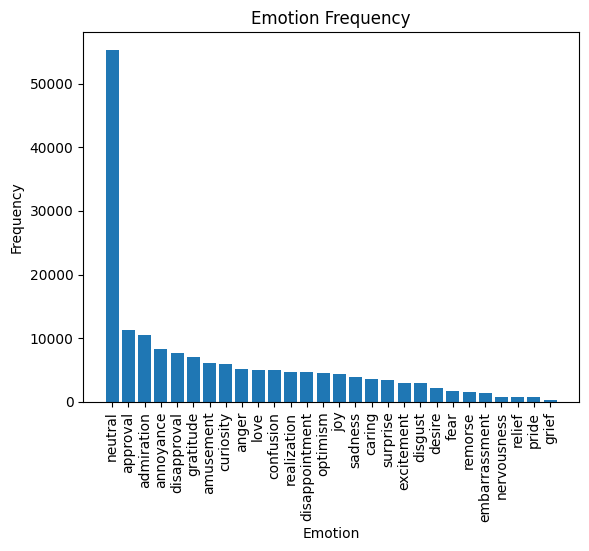

In [8]:
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.title("Emotion Frequency")
plt.xticks(rotation= 90) #done for readbility purposes
plt.bar(emotion_values, emotion_frequency)
plt.savefig("bar_emotion.png")
plt.show()

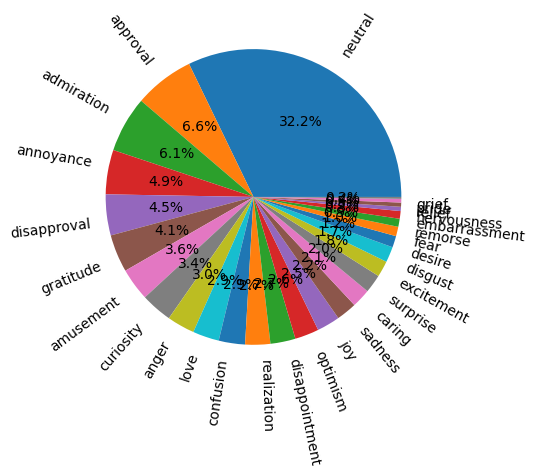

In [9]:
emotionLabels = []
sizes = []
for x, y in emotion.items():
    emotionLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=emotionLabels, rotatelabels = True, autopct ='%1.1f%%')
plt.savefig("pie_emotion.png")
plt.show()


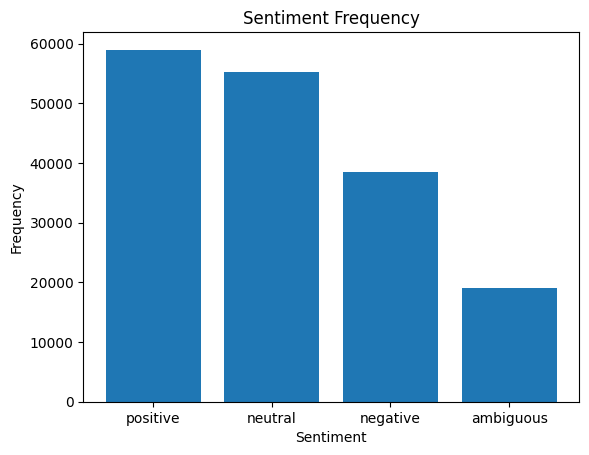

In [10]:
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Sentiment Frequency")
plt.bar(sentiment_values, sentiment_frequency)
plt.savefig("bar_sentiment.png")
plt.show()

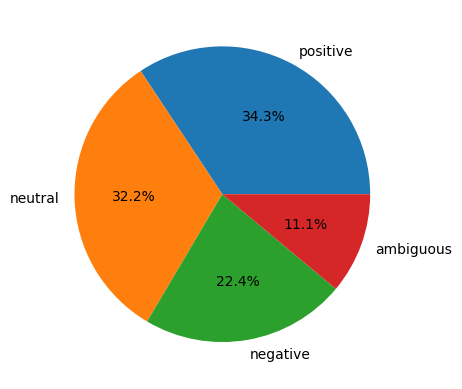

In [11]:
sentimentLabels = []
sizes = []
for x, y in sentiment.items():
    sentimentLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=sentimentLabels, autopct ='%1.1f%%')
plt.savefig("pie_sentiment.png")
plt.show()


Plotting of Frequency vs. Emotion and Frequency vs. Sentiment <br>
Source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html

<h1>extract tokens/words</h1>

In [12]:
post = file[0].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(post)
# vectorizer.get_feature_names_out()

In [13]:
print(f"The number of unique words is {len(X.toarray()[0])} unique words")

The number of unique words is 30449 unique words


Given that when X.toarray() is used, the occurrences of words in a post is counted for example <br> "This document is the second document."<br> the word document is used twice [0 2 0 1 0 1 1 0 1] mapping to the array of unique words ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
<br>
Sources: <br>
https://stackoverflow.com/questions/27488446/how-do-i-get-word-frequency-in-a-corpus-using-scikit-learn-countvectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [14]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1]) #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2]) #change 0 to the column of sentiment with no separation

<h2>2.2 Training and Test data split</h2>

In [15]:
#Question 2.2
X_train,X_test,yemo_train, yemo_test,ysent_train, ysent_test = train_test_split(X,encodedEmo,encodedSentiment, test_size = 0.2, train_size=0.8)

In [16]:
def metrics(true_y,prediction_y):
    print(f"Accuracy for Emotion: {accuracy_score(y_true=true_y,y_pred= prediction_y)}")
    print(f"Precision (Weighted) for Emotion: {precision_score(y_true=true_y,y_pred= prediction_y, average='weighted')}")
    print(f"F1 Score (Weighted) for Emotion: {f1_score(y_true=true_y,y_pred= prediction_y,average='weighted')}")
    print(f"F1 Score (Macro) for Emotion: {f1_score(y_true=true_y,y_pred= prediction_y,average='macro')}")
    print(classification_report(y_true=true_y,y_pred= prediction_y, zero_division='warn'))
    confusion_matrix(y_true=true_y,y_pred= prediction_y)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html)
with the default parameters.</h2>

Source: https://www.delftstack.com/howto/python/how-to-get-dictionary-keys-as-a-list-in-python/

In [17]:
classifier = MultinomialNB()
if (os.path.exists('models/MNB1_model.pickle')):
    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2_model.pickle')):
    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

Score for Emotion: 0.43920963799324875
Accuracy for Emotion: 0.43920963799324875
Precision (Weighted) for Emotion: 0.49050402087487255
F1 Score (Weighted) for Emotion: 0.37287880217234204
F1 Score (Macro) for Emotion: 0.22766194191863365
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      2026
           1       0.60      0.38      0.46      1206
           2       0.52      0.19      0.28      1074
           3       0.42      0.15      0.22      1648
           4       0.45      0.18      0.25      2282
           5       0.47      0.10      0.16       696
           6       0.56      0.10      0.18      1020
           7       0.55      0.17      0.26      1174
           8       0.65      0.06      0.11       417
           9       0.52      0.08      0.13       984
          10       0.48      0.17      0.25      1537
          11       0.59      0.11      0.19       529
          12       1.00      0.03      0.06       280
     

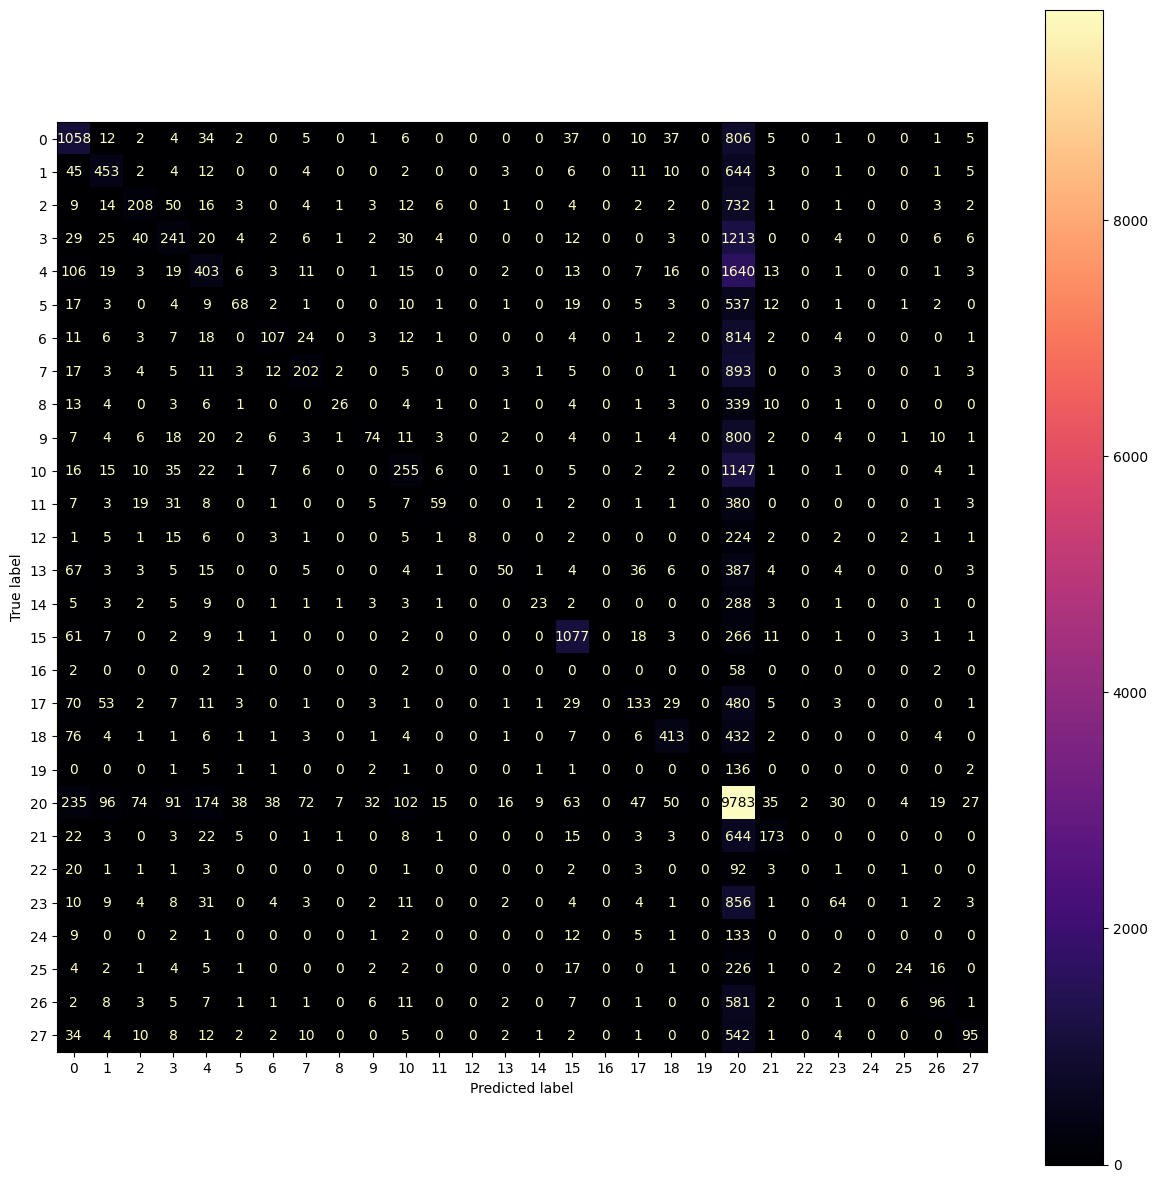

In [18]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.6041787917588174
Accuracy for Emotion: 0.6041787917588174
Precision (Weighted) for Emotion: 0.5992045086016413
F1 Score (Weighted) for Emotion: 0.5967786840196769
F1 Score (Macro) for Emotion: 0.563723343556038
              precision    recall  f1-score   support

           0       0.55      0.31      0.40      3949
           1       0.59      0.60      0.60      7672
           2       0.56      0.56      0.56     11059
           3       0.65      0.75      0.70     11684

    accuracy                           0.60     34364
   macro avg       0.59      0.55      0.56     34364
weighted avg       0.60      0.60      0.60     34364



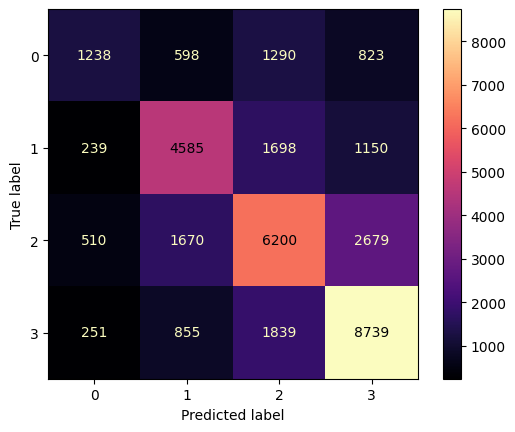

In [19]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>cross validation</h2>
<body>from sklearn.model_selection import cross_val_score</body>

<h2>Decision Tree (tree.DecisionTreeClassifier) with the default parameters.</h2>

In [20]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/DT1_model.pickle')):
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)


if (os.path.exists('models/DT2_model.pickle')):

    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotion: 0.5939064136887441
Accuracy for Emotion: 0.5939064136887441
Precision (Weighted) for Emotion: 0.6115864537099004
F1 Score (Weighted) for Emotion: 0.5904923112201067
F1 Score (Macro) for Emotion: 0.5131431927302328
              precision    recall  f1-score   support

           0       0.56      0.81      0.66      2026
           1       0.57      0.80      0.67      1206
           2       0.46      0.74      0.57      1074
           3       0.40      0.58      0.47      1648
           4       0.45      0.57      0.51      2282
           5       0.48      0.56      0.52       696
           6       0.49      0.58      0.53      1020
           7       0.58      0.60      0.59      1174
           8       0.49      0.55      0.52       417
           9       0.47      0.46      0.46       984
          10       0.52      0.49      0.50      1537
          11       0.52      0.39      0.45       529
          12       0.53      0.42      0.47       280
          

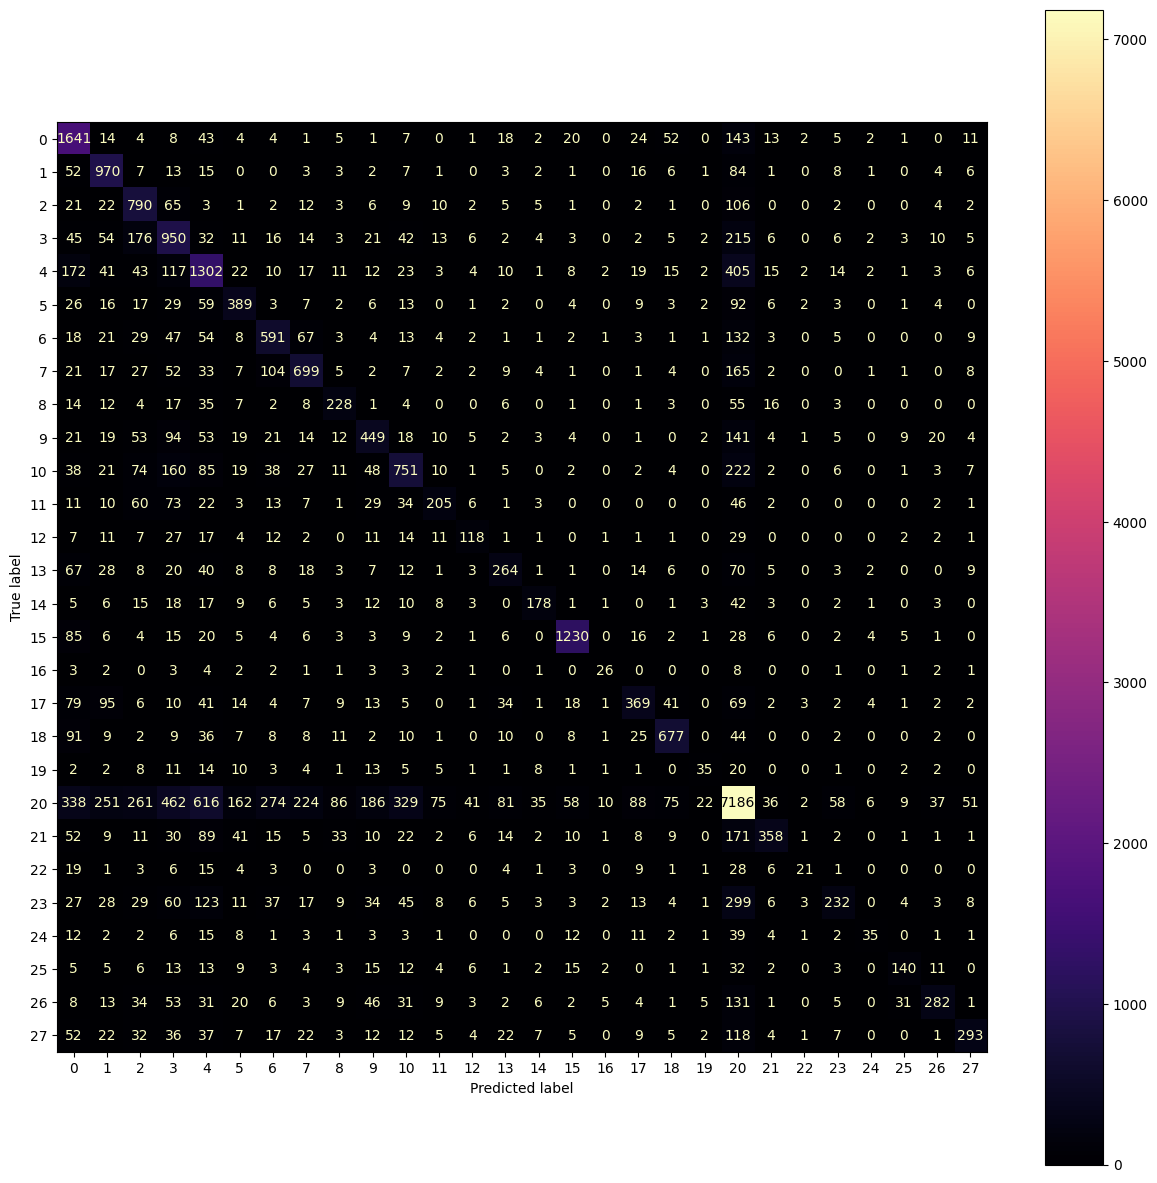

In [21]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')


Score for Sentiment: 0.7173204516354325
Accuracy for Emotion: 0.7173204516354325
Precision (Weighted) for Emotion: 0.7283940177368383
F1 Score (Weighted) for Emotion: 0.7194997260415413
F1 Score (Macro) for Emotion: 0.705277647672712
              precision    recall  f1-score   support

           0       0.57      0.71      0.64      3949
           1       0.67      0.78      0.72      7672
           2       0.71      0.67      0.69     11059
           3       0.84      0.73      0.78     11684

    accuracy                           0.72     34364
   macro avg       0.70      0.72      0.71     34364
weighted avg       0.73      0.72      0.72     34364



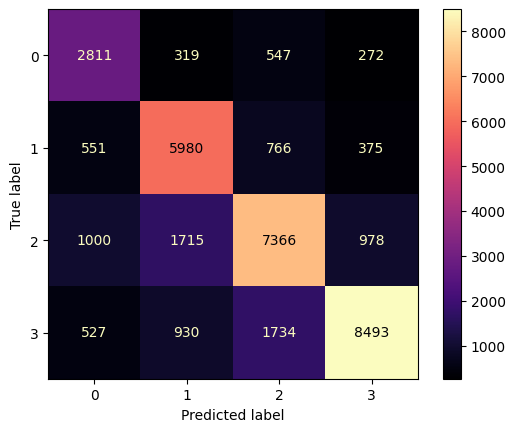

In [22]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.</h2>

In [23]:
classifier = MLPClassifier(max_iter=50)
if (os.path.exists('models/MLP1_model.pickle')):
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP1 = classifier.fit(X_train, yemo_train)
    with open('models/MLP1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MLP2_model.pickle')):
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP2 = classifier.fit(X_train,ysent_train)
    with open('models/MLP2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotion: 0.5744674659527412
Accuracy for Emotion: 0.5744674659527412
Precision (Weighted) for Emotion: 0.5683997298348148
F1 Score (Weighted) for Emotion: 0.5688402897521253
F1 Score (Macro) for Emotion: 0.5025884111875707
              precision    recall  f1-score   support

           0       0.63      0.69      0.66      2026
           1       0.63      0.66      0.64      1206
           2       0.53      0.52      0.53      1074
           3       0.44      0.39      0.41      1648
           4       0.49      0.39      0.43      2282
           5       0.49      0.46      0.47       696
           6       0.52      0.45      0.48      1020
           7       0.56      0.47      0.51      1174
           8       0.45      0.53      0.49       417
           9       0.44      0.40      0.42       984
          10       0.45      0.47      0.46      1537
          11       0.48      0.44      0.46       529
          12       0.44      0.42      0.43       280
          

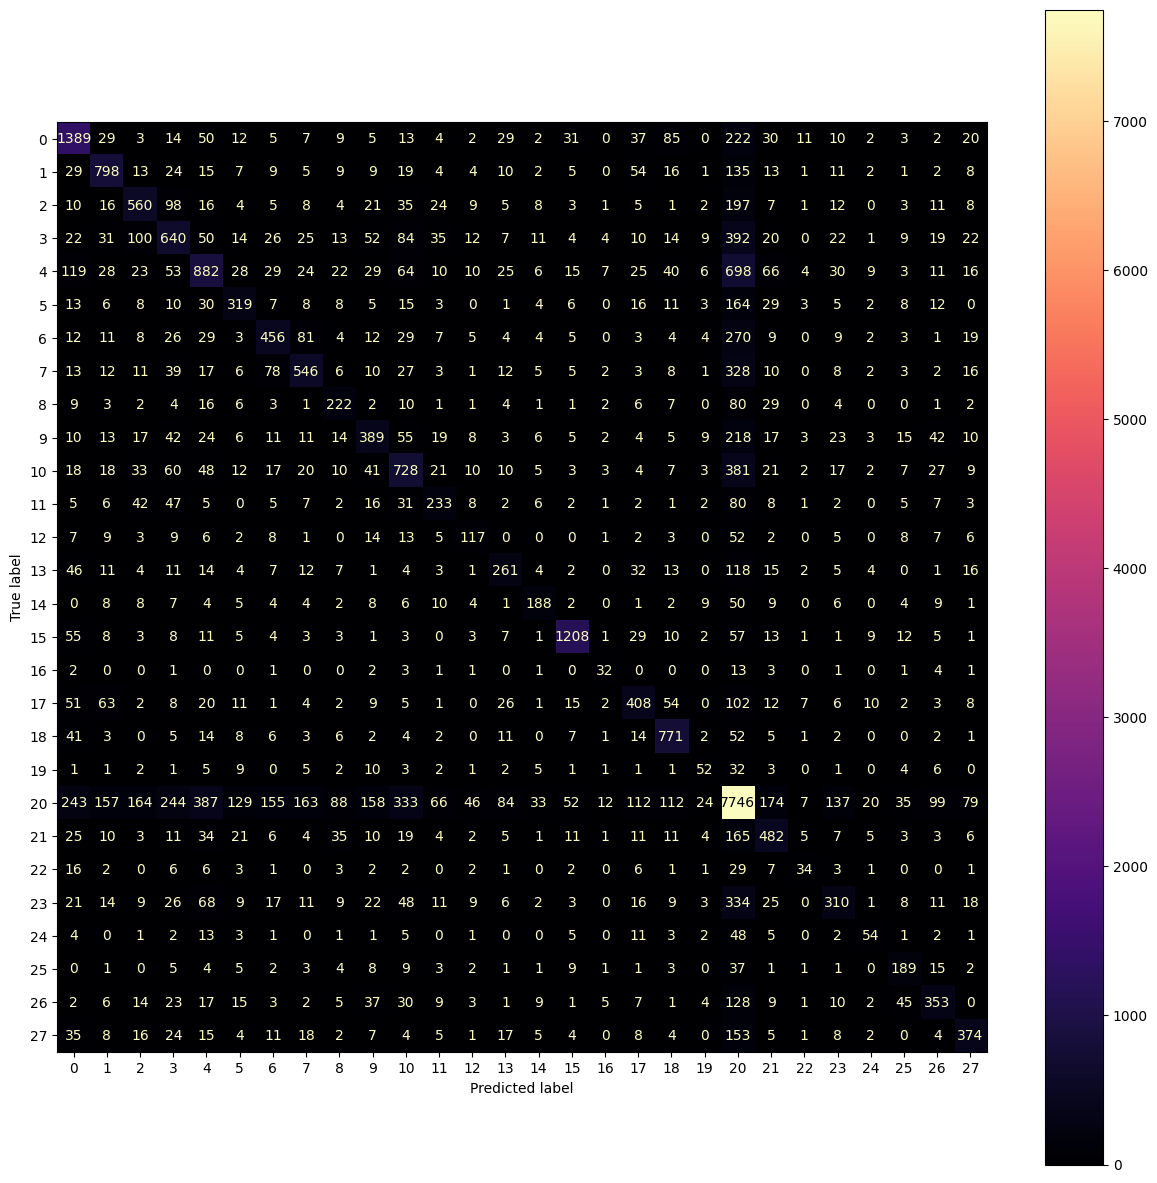

In [24]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.6381387498544989
Accuracy for Emotion: 0.6381387498544989
Precision (Weighted) for Emotion: 0.6362853970777097
F1 Score (Weighted) for Emotion: 0.6314138689482885
F1 Score (Macro) for Emotion: 0.5950971441692151
              precision    recall  f1-score   support

           0       0.60      0.31      0.41      3949
           1       0.61      0.66      0.64      7672
           2       0.59      0.62      0.60     11059
           3       0.71      0.75      0.73     11684

    accuracy                           0.64     34364
   macro avg       0.63      0.59      0.60     34364
weighted avg       0.64      0.64      0.63     34364



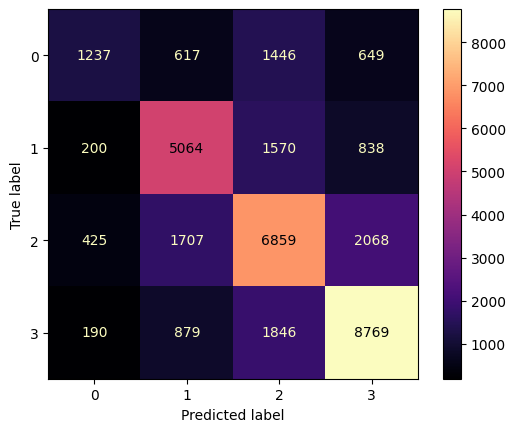

In [25]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1


In [26]:
parameters = {"alpha":(0.5,0,0.36,1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/MNB1GridCV_model.pickle')):
    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2GridCV_model.pickle')):
    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Best estimator (Emotion): MultinomialNB(alpha=0.36), Best Score: 0.3834754477508645
Accuracy for Emotion: 0.484227680130369
Precision (Weighted) for Emotion: 0.47847237168914364
F1 Score (Weighted) for Emotion: 0.4585172557094725
F1 Score (Macro) for Emotion: 0.35475112575917417
              precision    recall  f1-score   support

           0       0.52      0.61      0.56      2026
           1       0.56      0.59      0.58      1206
           2       0.47      0.39      0.43      1074
           3       0.37      0.23      0.28      1648
           4       0.43      0.26      0.33      2282
           5       0.37      0.30      0.33       696
           6       0.45      0.27      0.33      1020
           7       0.50      0.33      0.40      1174
           8       0.54      0.25      0.34       417
           9       0.44      0.20      0.27       984
          10       0.42      0.30      0.35      1537
          11       0.48      0.29      0.36       529
          12     

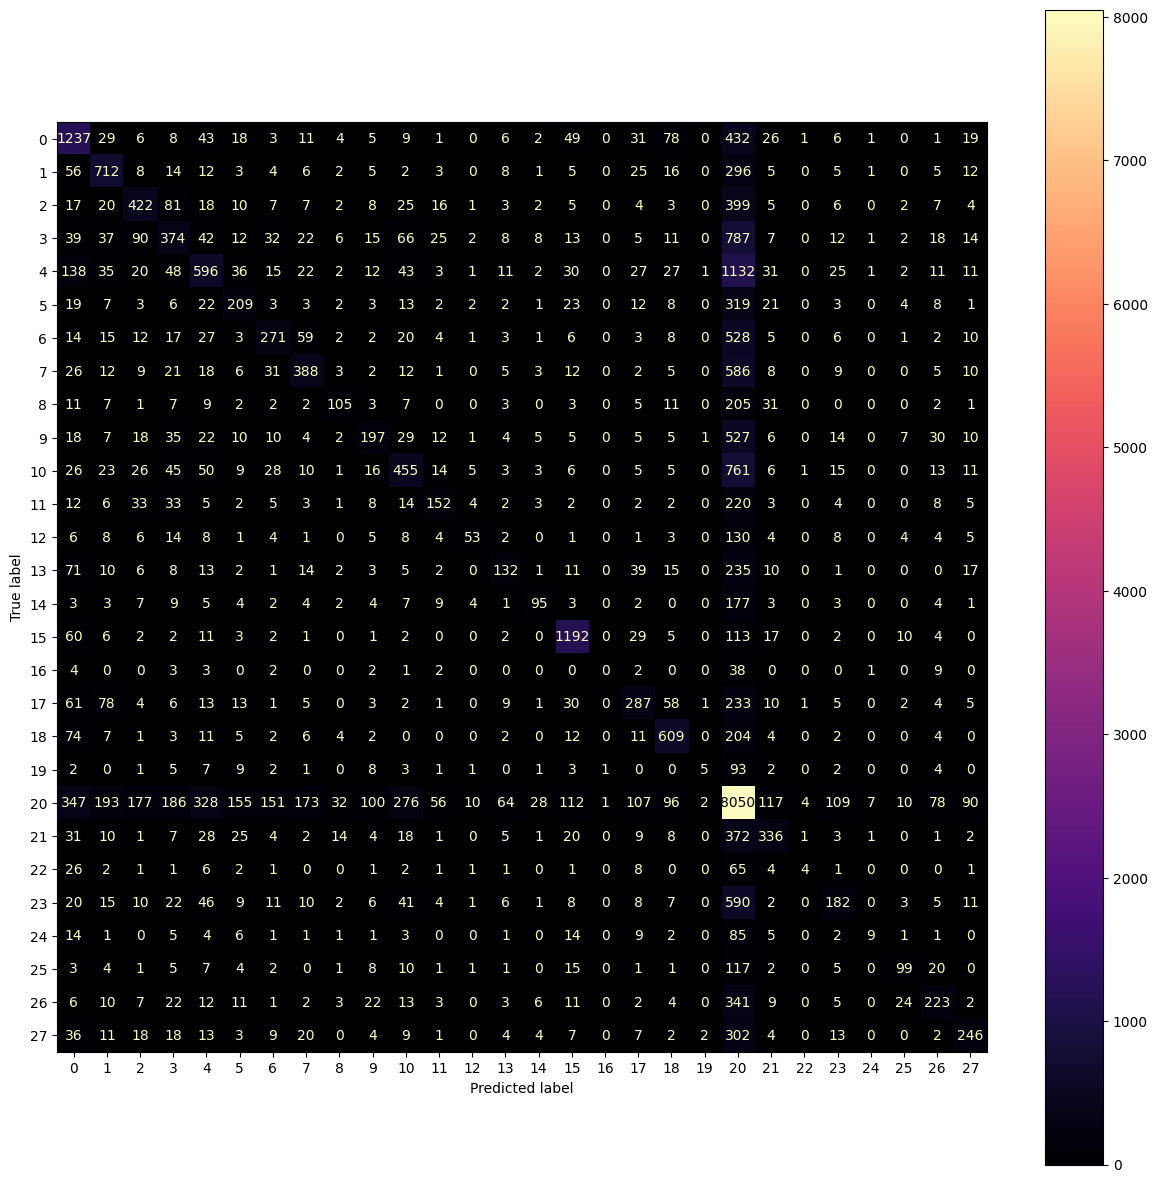

In [27]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Best estimator (Sentiment): MultinomialNB(alpha=1), Best Score: 0.5383904367141189
Accuracy for Emotion: 0.6037422884413921
Precision (Weighted) for Emotion: 0.5981341012460261
F1 Score (Weighted) for Emotion: 0.5964044111789902
F1 Score (Macro) for Emotion: 0.5624777565400191
              precision    recall  f1-score   support

           0       0.54      0.31      0.40      3949
           1       0.59      0.59      0.59      7672
           2       0.56      0.56      0.56     11059
           3       0.66      0.75      0.70     11684

    accuracy                           0.60     34364
   macro avg       0.59      0.55      0.56     34364
weighted avg       0.60      0.60      0.60     34364



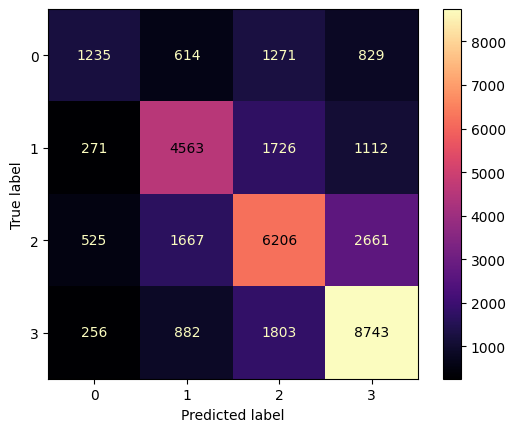

In [28]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Decision Tree Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples


In [29]:
parameters = {"criterion":("gini","entropy"),"max_depth":(100,3),"min_samples_split":(12,5,30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/DT1GridCV_model.pickle')):
    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/DT2GridCV_model.pickle')):
    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.4044639513068846
Accuracy for Emotion: 0.5023280176929344
Precision (Weighted) for Emotion: 0.5077477591892989
F1 Score (Weighted) for Emotion: 0.46097847396789926
F1 Score (Macro) for Emotion: 0.36063332686595606
              precision    recall  f1-score   support

           0       0.58      0.55      0.57      2026
           1       0.58      0.64      0.61      1206
           2       0.48      0.35      0.40      1074
           3       0.36      0.19      0.25      1648
           4       0.43      0.20      0.27      2282
           5       0.42      0.22      0.29       696
           6       0.47      0.23      0.31      1020
           7       0.52      0.25      0.33      1174
           8       0.48      0.27      0.35       417
           9       0.45      0.16      0.24       984
          10       0.45      0.22      0.30      1537
          11       0.51      0.25   

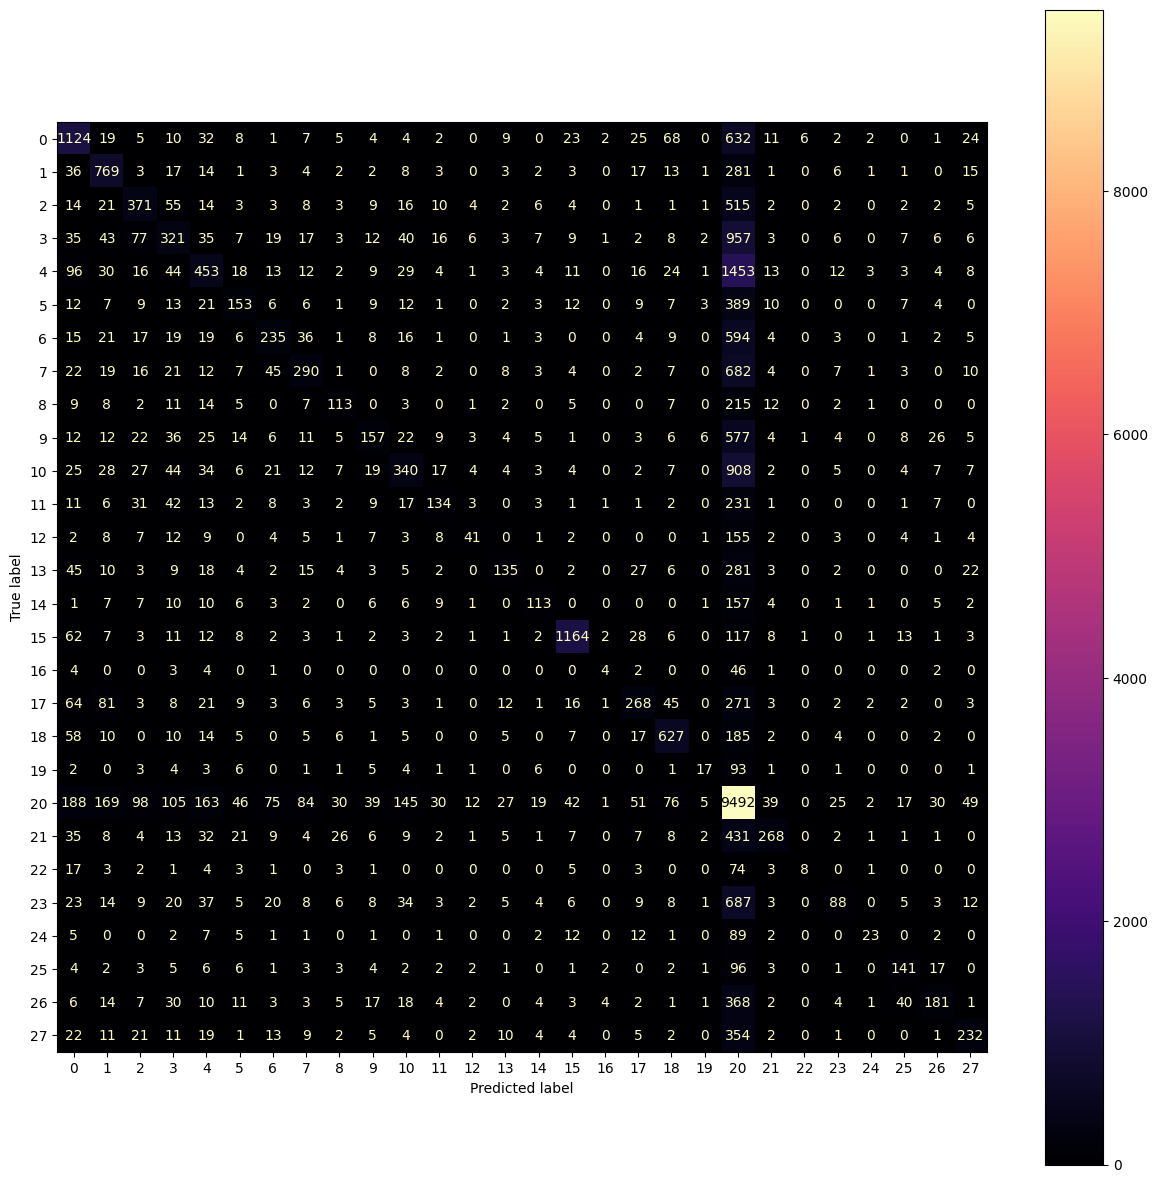

In [30]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.515219404662324
Accuracy for Emotion: 0.6202130136189035
Precision (Weighted) for Emotion: 0.6643875377154008
F1 Score (Weighted) for Emotion: 0.6218028844653486
F1 Score (Macro) for Emotion: 0.5967577030271484
              precision    recall  f1-score   support

           0       0.55      0.44      0.49      3949
           1       0.69      0.51      0.58      7672
           2       0.51      0.79      0.62     11059
           3       0.84      0.60      0.70     11684

    accuracy                           0.62     34364
   macro avg       0.65      0.58      0.60     34364
weighted avg       0.66      0.62      0.62     34364



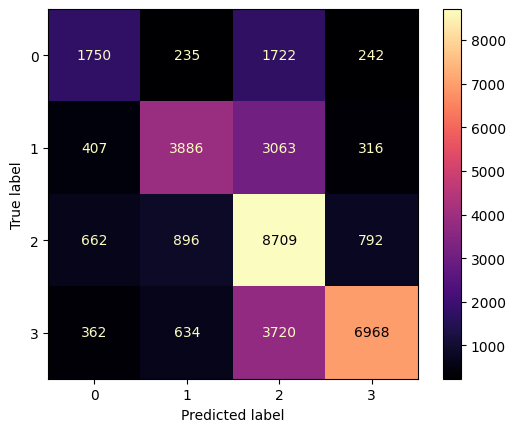

In [31]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [32]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(max_iter=50)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters)
skip=True
if(not skip):
    if (os.path.exists('models/MLP1GridCV_model.pickle')):
        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/MLP1GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/MLP2GridCV_model.pickle')):
        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/MLP2GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

skipped


In [33]:
if (os.path.exists('models/MLP1GridCV_model.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

skipped


In [34]:
if (os.path.exists('models/MLP2GridCV_model.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

skipped


<h3>2.5</h3>
Test/Training split: 80/20 -> 95/5
Anticipated effect: increased accuracy but poor generalization


In [35]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1])  #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2])  #change 0 to the column of sentiment with no separation



In [36]:
X_train, X_test, yemo_train, yemo_test, ysent_train, ysent_test = train_test_split(X, encodedEmo, encodedSentiment,test_size=0.5, train_size=0.5)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html) using new test train split</h2>

In [37]:
classifier = MultinomialNB()
if (os.path.exists('models/new_split/MNB1_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")

else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotion: 0.4501571411942731
Accuracy for Emotion: 0.4501571411942731
Precision (Weighted) for Emotion: 0.495927836135357
F1 Score (Weighted) for Emotion: 0.3911910543509185
F1 Score (Macro) for Emotion: 0.25118839432320367
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      5140
           1       0.62      0.42      0.50      3089
           2       0.52      0.21      0.30      2621
           3       0.42      0.17      0.24      4248
           4       0.46      0.18      0.26      5659
           5       0.45      0.13      0.21      1719
           6       0.53      0.13      0.21      2465
           7       0.55      0.19      0.28      2955
           8       0.63      0.07      0.12      1086
           9       0.52      0.11      0.18      2295
          10       0.43      0.17      0.25      3811
          11       0.59      0.15      0.24      1458
          12       0.67      0.04      0.07       702
          

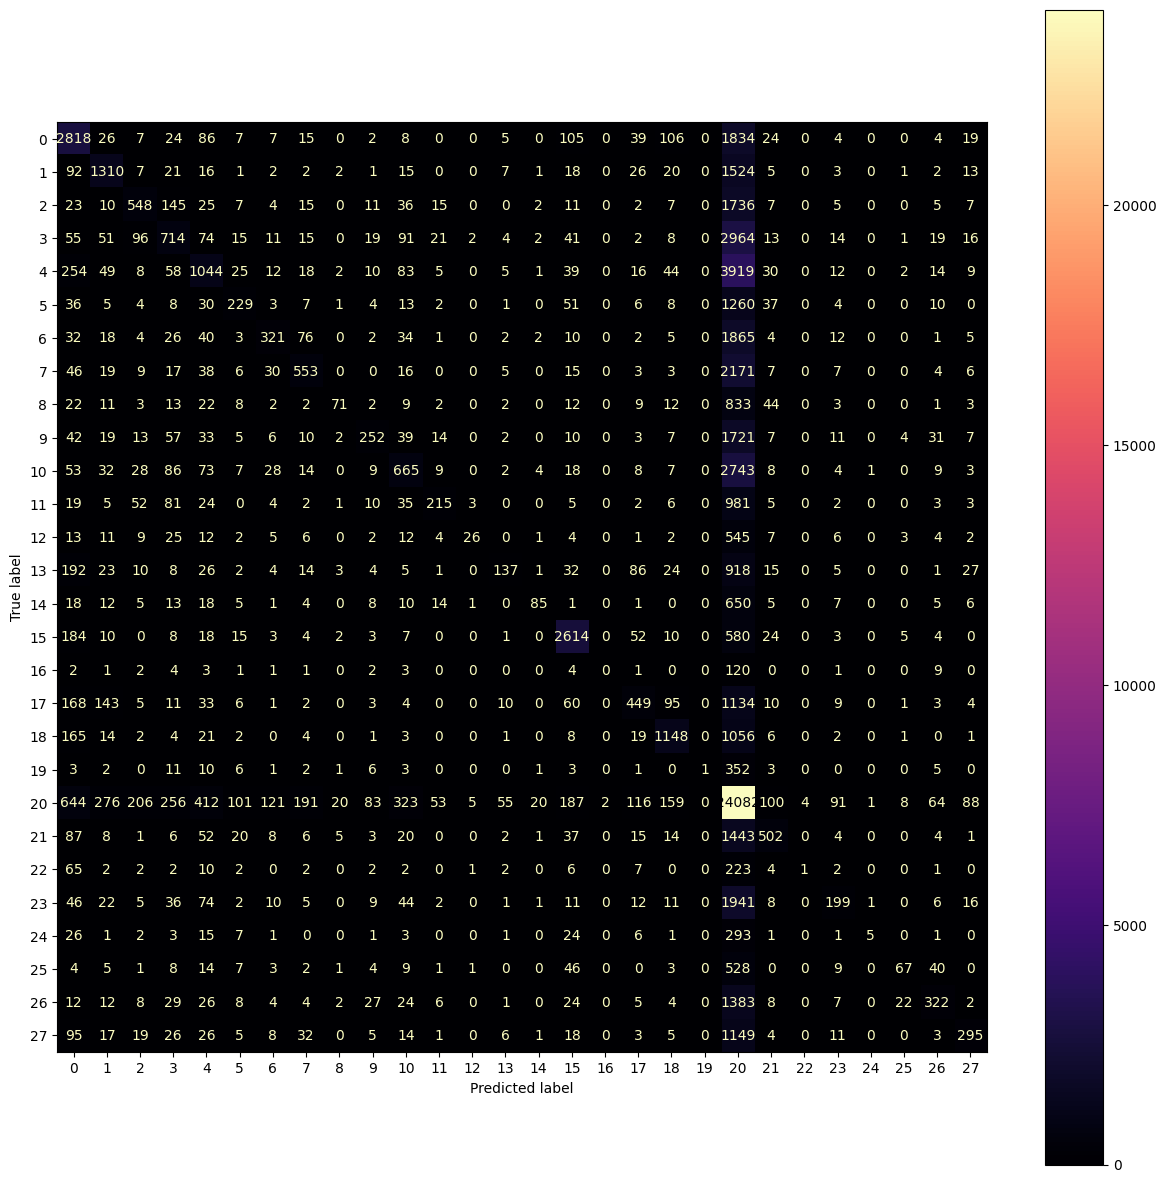

In [38]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.6150157141194273
Accuracy for Emotion: 0.6150157141194273
Precision (Weighted) for Emotion: 0.6099119700901127
F1 Score (Weighted) for Emotion: 0.6090667101275319
F1 Score (Macro) for Emotion: 0.5772989325556712
              precision    recall  f1-score   support

           0       0.55      0.34      0.42      9625
           1       0.61      0.61      0.61     19263
           2       0.57      0.57      0.57     27668
           3       0.66      0.75      0.70     29354

    accuracy                           0.62     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.62      0.61     85910



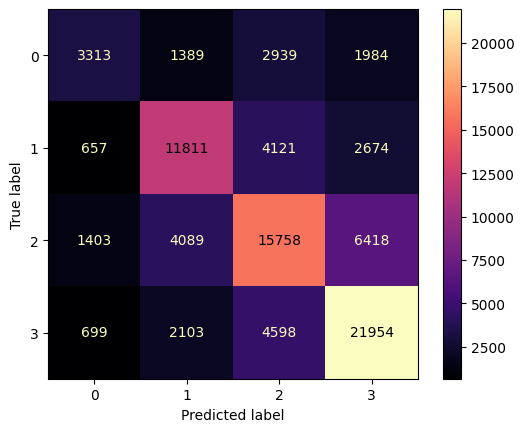

In [39]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Decision Tree (tree.DecisionTreeClassifier) using new test train split</h2>

In [40]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/new_split/DT1_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotion: 0.6177394948201607
Accuracy for Emotion: 0.6177394948201607
Precision (Weighted) for Emotion: 0.628515809786082
F1 Score (Weighted) for Emotion: 0.6123662132221367
F1 Score (Macro) for Emotion: 0.5359317668256158
              precision    recall  f1-score   support

           0       0.58      0.82      0.68      5140
           1       0.60      0.83      0.70      3089
           2       0.48      0.71      0.57      2621
           3       0.43      0.58      0.50      4248
           4       0.48      0.54      0.51      5659
           5       0.49      0.58      0.53      1719
           6       0.51      0.55      0.53      2465
           7       0.60      0.61      0.61      2955
           8       0.56      0.55      0.55      1086
           9       0.48      0.45      0.47      2295
          10       0.56      0.49      0.52      3811
          11       0.60      0.42      0.49      1458
          12       0.55      0.40      0.47       702
          1

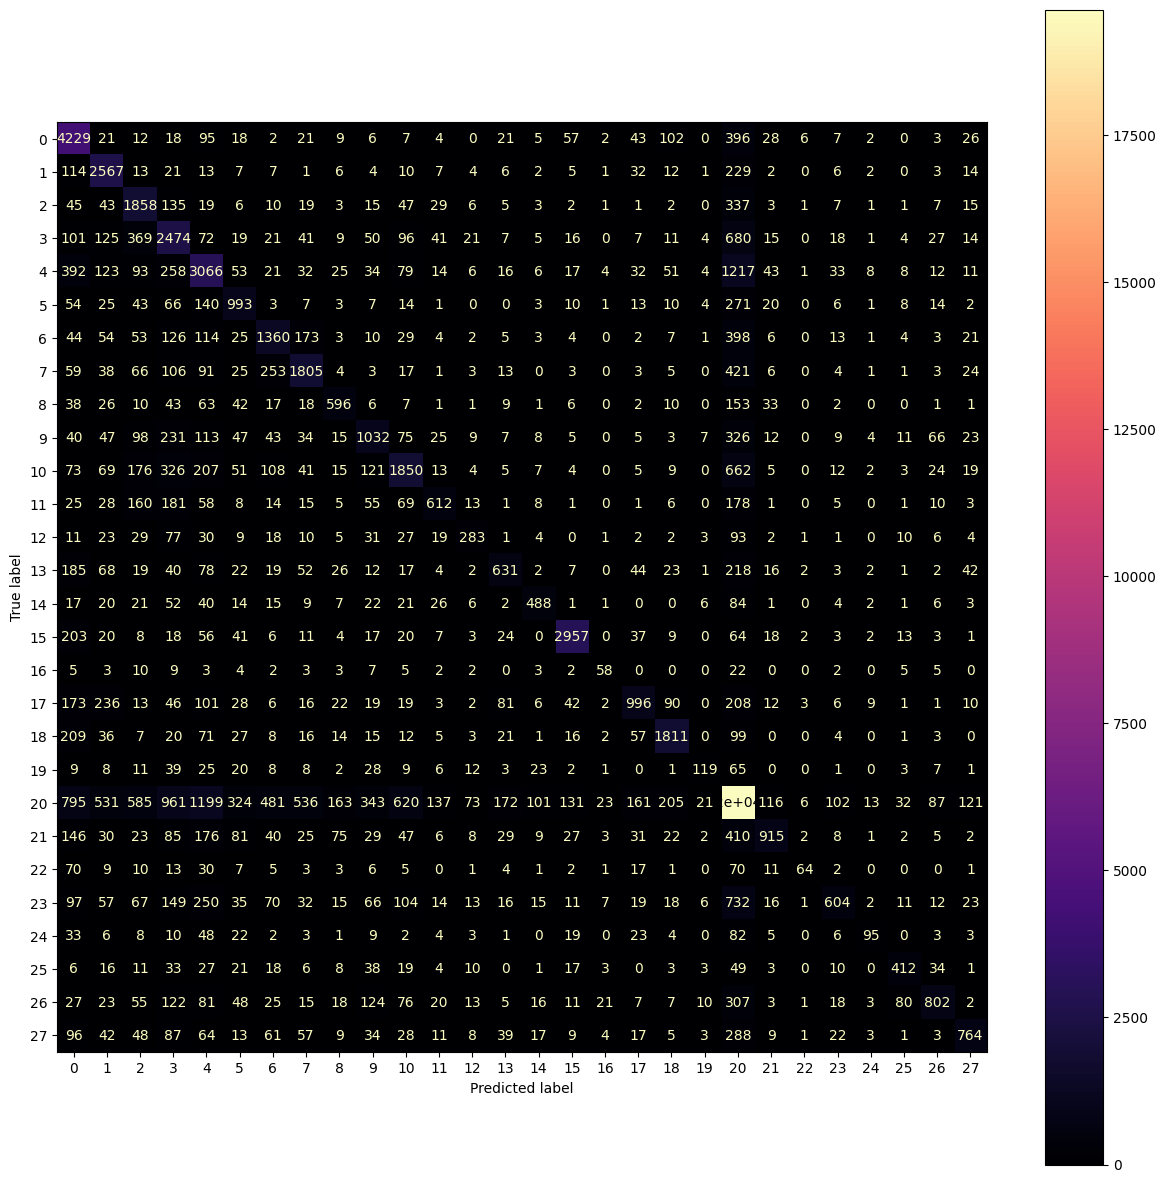

In [41]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.7371435222907694
Accuracy for Emotion: 0.7371435222907694
Precision (Weighted) for Emotion: 0.7443124653621156
F1 Score (Weighted) for Emotion: 0.7387659038999457
F1 Score (Macro) for Emotion: 0.723461968663833
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      9625
           1       0.69      0.79      0.74     19263
           2       0.73      0.69      0.71     27668
           3       0.84      0.76      0.79     29354

    accuracy                           0.74     85910
   macro avg       0.72      0.74      0.72     85910
weighted avg       0.74      0.74      0.74     85910



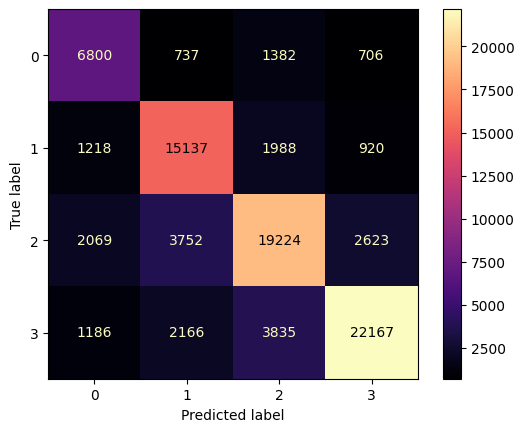

In [42]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) using new test train split</h2>

<b>Did not converge timed out</b>

In [43]:
classifier = MLPClassifier(max_iter=50)
skip=True
if(not skip):
    if (os.path.exists('models/new_split/MLP1_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP1 = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP2 = classifier.fit(X_train, ysent_train)
        with open('models/new_split/MLP2_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

skipped


In [44]:

if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.predict(X_test)
    print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
    metrics(yemo_test, y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
    fig, ax = plt.subplots(figsize=(15, 15))
    cmp.plot(ax=ax, cmap='magma')
else:
    print("skipped")

skipped


In [45]:
if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.predict(X_test)

    print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
    metrics(ysent_test, y_sent_predict)
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

skipped


<h2>Multinomial Naive Bayes Classifier found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1

In [46]:
parameters = {"alpha": (0.5, 0, 0.36, 1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/MNB1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Best estimator (Emotion): MultinomialNB(alpha=0.5), Best Score: 0.3905984755012737
Accuracy for Emotion: 0.484972645792108
Precision (Weighted) for Emotion: 0.48675396883962435
F1 Score (Weighted) for Emotion: 0.4542880218897119
F1 Score (Macro) for Emotion: 0.34441132642863465
              precision    recall  f1-score   support

           0       0.53      0.61      0.57      5140
           1       0.59      0.59      0.59      3089
           2       0.49      0.34      0.40      2621
           3       0.40      0.24      0.30      4248
           4       0.43      0.24      0.31      5659
           5       0.39      0.28      0.33      1719
           6       0.45      0.24      0.31      2465
           7       0.50      0.31      0.38      2955
           8       0.59      0.21      0.31      1086
           9       0.45      0.20      0.27      2295
          10       0.41      0.27      0.33      3811
          11       0.50      0.26      0.34      1458
          12      

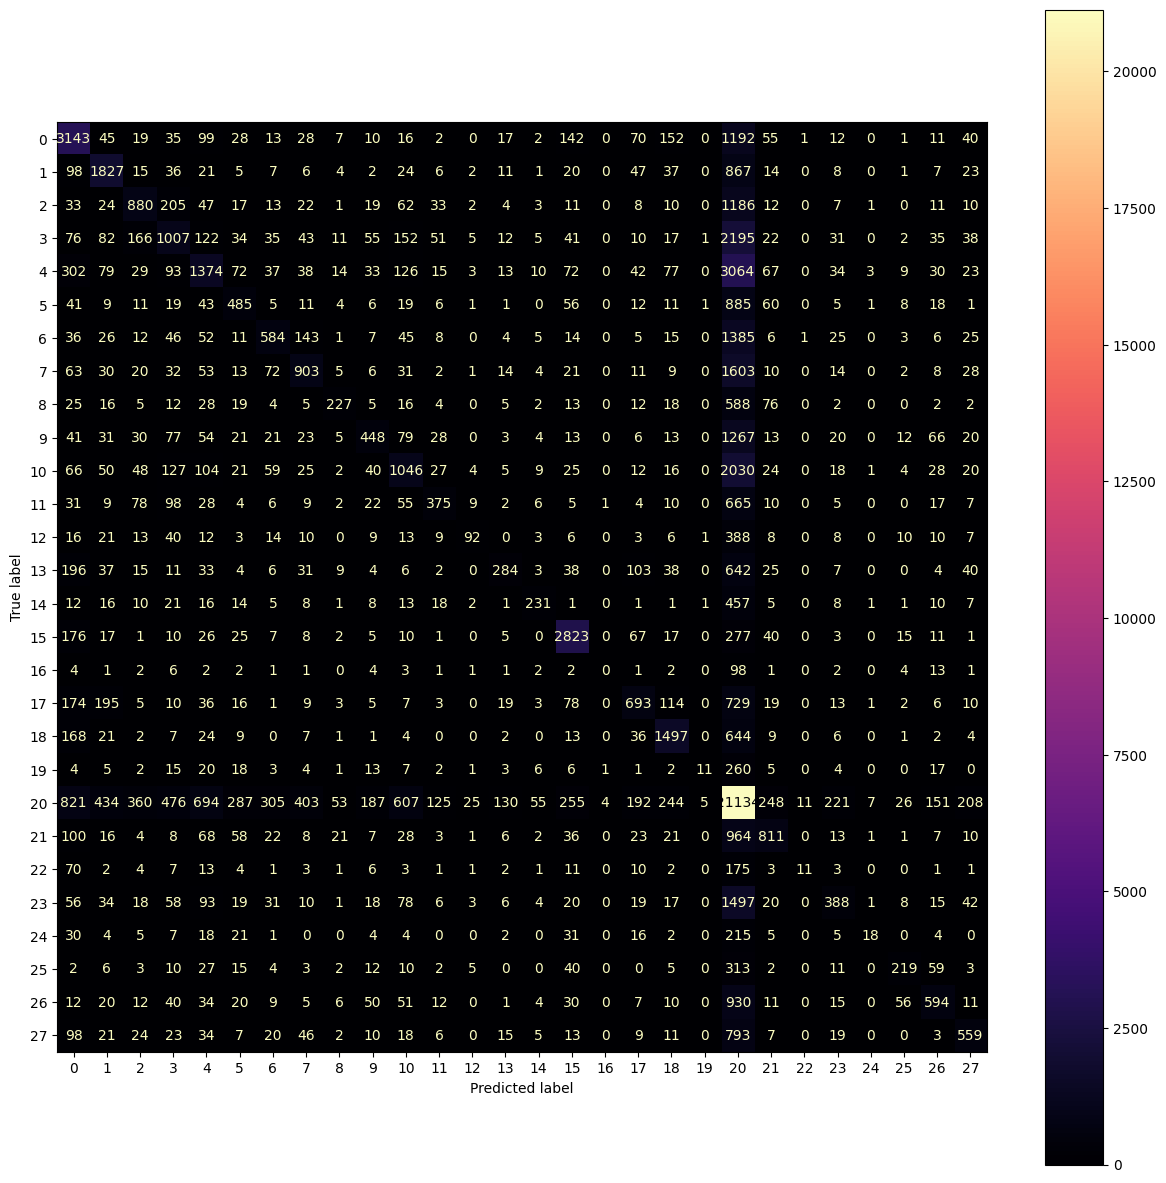

In [47]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): MultinomialNB(alpha=1), Best Score: 0.543696292227927
Accuracy for Emotion: 0.6150157141194273
Precision (Weighted) for Emotion: 0.6099119700901127
F1 Score (Weighted) for Emotion: 0.6090667101275319
F1 Score (Macro) for Emotion: 0.5772989325556712
              precision    recall  f1-score   support

           0       0.55      0.34      0.42      9625
           1       0.61      0.61      0.61     19263
           2       0.57      0.57      0.57     27668
           3       0.66      0.75      0.70     29354

    accuracy                           0.62     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.62      0.61     85910



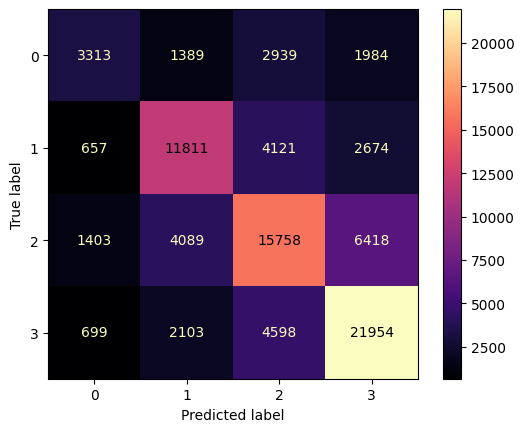

In [48]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>DecisionTree Classifier found using GridSearchCV and new test train split </h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples

In [49]:
parameters = {"criterion": ("gini", "entropy"), "max_depth": (100, 3), "min_samples_split": (12, 5, 30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/DT1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.3984285880572692
Accuracy for Emotion: 0.4690024444185776
Precision (Weighted) for Emotion: 0.4583420045522845
F1 Score (Weighted) for Emotion: 0.4228816433480527
F1 Score (Macro) for Emotion: 0.3203977748078894
              precision    recall  f1-score   support

           0       0.54      0.51      0.52      5140
           1       0.58      0.59      0.58      3089
           2       0.45      0.26      0.33      2621
           3       0.29      0.15      0.20      4248
           4       0.35      0.15      0.21      5659
           5       0.33      0.14      0.20      1719
           6       0.41      0.20      0.27      2465
           7       0.45      0.22      0.30      2955
           8       0.49      0.29      0.36      1086
           9       0.34      0.13      0.19      2295
          10       0.34      0.15      0.21      3811
          11       0.43      0.21     

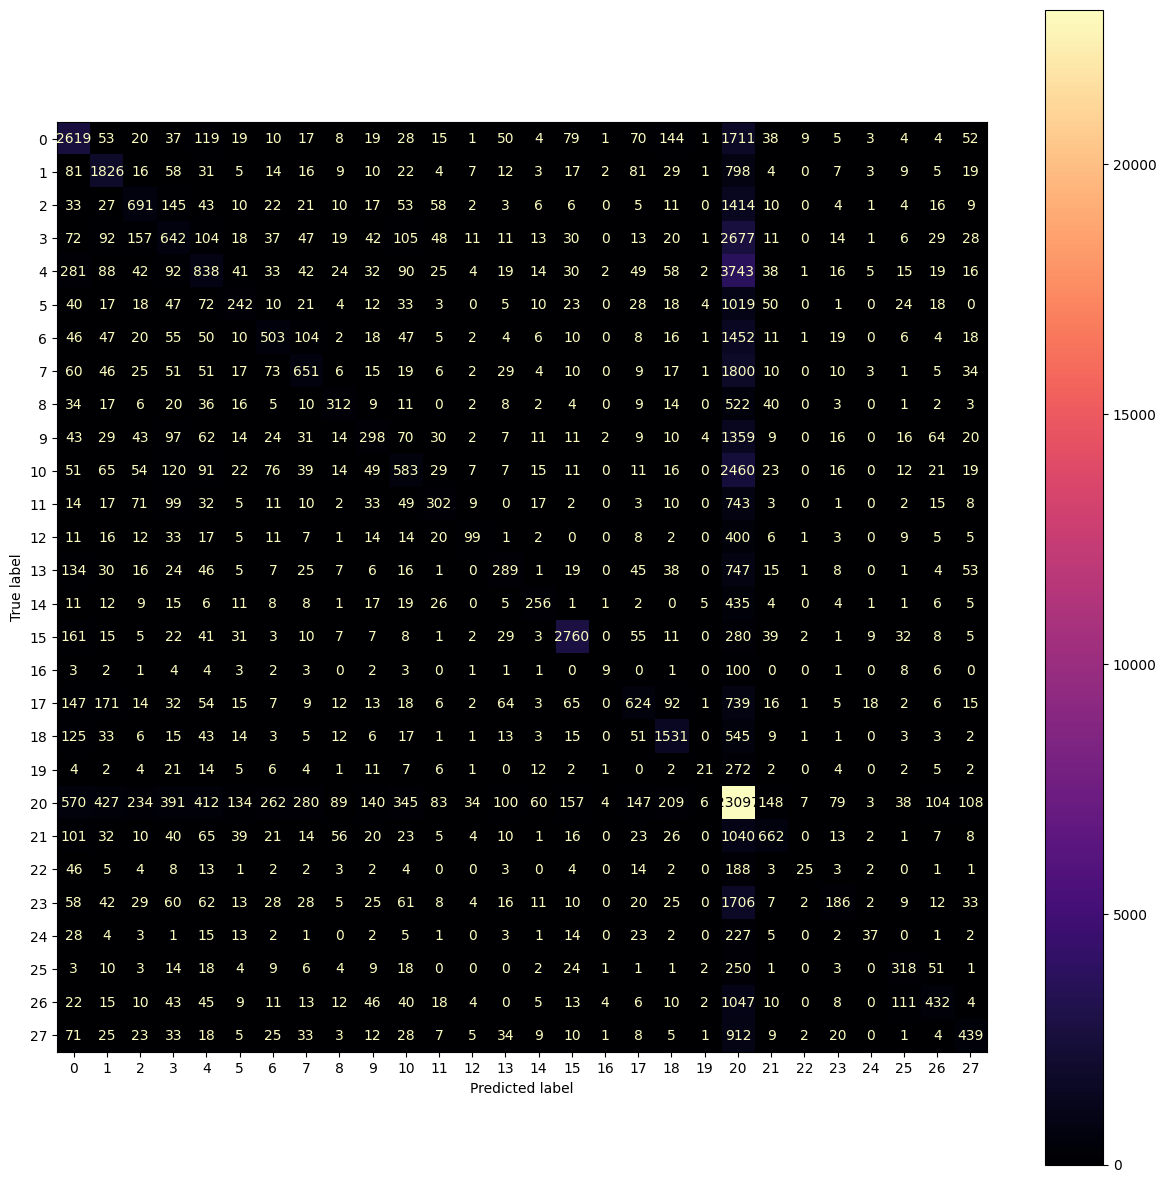

In [50]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.49976719823070653
Accuracy for Emotion: 0.5825631474799209
Precision (Weighted) for Emotion: 0.6277845303004053
F1 Score (Weighted) for Emotion: 0.5807387411094707
F1 Score (Macro) for Emotion: 0.5483012267166949
              precision    recall  f1-score   support

           0       0.52      0.34      0.41      9625
           1       0.65      0.45      0.53     19263
           2       0.47      0.78      0.59     27668
           3       0.80      0.57      0.66     29354

    accuracy                           0.58     85910
   macro avg       0.61      0.53      0.55     85910
weighted avg       0.63      0.58      0.58     85910



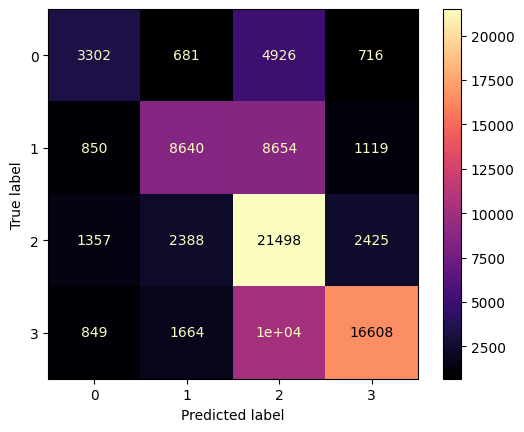

In [51]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [52]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier()
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters)
skip=True
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/new_split/MLP2GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

skipped


In [53]:
if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

skipped


In [54]:
if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

skipped


<h3>3. Embedding as features</h3>

requires install of library gensim

pip install gensim

https://radimrehurek.com/gensim/models/word2vec.html


In [55]:
# result.most_similar("cat")

In [56]:
if (os.path.exists('models/word2vec.pickle')):
    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)
    print("pickle file used")
else:
    model =gensim.downloader.load("word2vec-google-news-300")
    with open('models/word2vec.pickle','wb') as f:
        pickle.dump(model, f)

    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)

pickle file used


In [57]:
nltk.download('punkt')
post.str.lower()
tokenized_word = [word_tokenize(i) for i in post]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
post_tokens = [post_tokens for post_tokens in tokenized_word] #http://librarycarpentry.org/lc-tdm/aio/index.html
unique_post_tokens = np.unique(post_tokens)
num_tokens = 0
print("Number of tokens in Reddit posts:")
for i in post_tokens:
    num_tokens=num_tokens+len(i)
print(num_tokens)
print(unique_post_tokens[0])

Number of tokens in Reddit posts:
2642128
['!', '!', '!', '!', '!', 'Best', 'girl']


In [59]:
model = Word2Vec(tokenized_word, min_count=1)
model.save('word2vec.model')